In [86]:
import torch
from PIL import Image
from torchvision import transforms, models
from sys import version
import timm
from tqdm import tqdm
import urllib
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt
import numpy as np
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler as Slearn_Scaler
import seaborn as sns
from functools import reduce
from math import sqrt, floor, ceil, prod
from numpy import linspace
from math import floor, ceil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter
import inspect
import pickle
import pandas as pd
from matplotlib.ticker import PercentFormatter
from matplotlib.pyplot import cm
from itertools import cycle
import logging
import matplotlib.ticker as mtick
from collections import Counter
from numpy.lib.stride_tricks import sliding_window_view
from math import floor
import multiprocessing
import os
from tqdm.contrib.concurrent import process_map  
from itertools import repeat

logging.getLogger('matplotlib').setLevel(logging.ERROR)
%matplotlib inline
# get_ipython().run_line_magic('matplotlib', 'inline')
version

'3.9.5 (default, Apr 15 2022, 15:04:02) \n[GCC 8.4.0]'

In [87]:
sns.set_style("darkgrid")

In [88]:
def get_ifmap_weight_reuse_for_layers_in_model(args):
        model, stats, longest_network_length = args
        model_length = len(stats['raw_stats'])
        idx_list = linspace(0, longest_network_length, model_length)
        model_ifmap_reuse = []
        model_weight_reuse = []
        model_ofmap_reuse = []
        for name, layer in stats['raw_stats'].items():
            if layer.input_size[-1] != layer.input_size[-2]:
                raise Exception("Invalid asymmetric input")
            ifmap_dims = layer.input_size[-2:]
            ifmap_dims = [dim+padding for dim, padding in zip(ifmap_dims, layer.padding)]
            ifmap = np.arange(np.prod(ifmap_dims)).reshape(ifmap_dims)
            stride_x = layer.stride[-1]
            stride_y = layer.stride[-2]
            ifmap_reuse = np.zeros(ifmap_dims)
            views = sliding_window_view(ifmap, layer.kernel_size)[::stride_x, ::stride_y]
            views = views.reshape(-1, *views.shape[-2:])
            for view in views:
                accessed_ifmaps = view.flatten()
                ifmap_y = [floor(pixel/ifmap_dims[0]) for pixel in accessed_ifmaps]
                ifmap_x = [pixel%ifmap_dims[0] for pixel in accessed_ifmaps]
                ifmap_reuse[ifmap_y, ifmap_x] += 1
            avg_ifmap_reuse = np.average(ifmap_reuse)
            filter_count = layer.output_size[0]
            channel_count = layer.input_size[1]
            avg_ifmap_reuse *= (filter_count/ layer.groups)
            avg_ifmap_reuse = avg_ifmap_reuse
            avg_weight_reuse = np.prod(layer.output_size[-2:])
            avg_ofmap_reuse = channel_count / layer.groups
            model_ifmap_reuse.append(avg_ifmap_reuse)
            model_weight_reuse.append(avg_weight_reuse)
            model_ofmap_reuse.append(avg_ofmap_reuse)
        interp_model_ifmap_reuse = np.interp(np.arange(longest_network_length), idx_list, model_ifmap_reuse)
        interp_model_weight_reuse = np.interp(np.arange(longest_network_length), idx_list, model_weight_reuse)
        interp_model_ofmap_reuse = np.interp(np.arange(longest_network_length), idx_list, model_ofmap_reuse)
        return (model, interp_model_ifmap_reuse, interp_model_weight_reuse, interp_model_ofmap_reuse)
    
def get_ifmap_weight_reuse_trends():

    def load_stats_dict():
        with open('../data/stats_dict.backup', 'rb') as backup:
            stats_dict = pickle.load(backup)
        return stats_dict
    stats_dict = load_stats_dict()
    ...    
    # longest_network_length = max([len(stats['raw_stats'].keys()) for model, stats in stats_dict.items()])
    
    # models_stats_dict_without_ssd = {m:s for m, s in stats_dict.items() if m!='ssd'}
    
    # args = list(zip(models_stats_dict_without_ssd.keys(), models_stats_dict_without_ssd.values(), repeat(longest_network_length)))
    
    # r = process_map(get_ifmap_weight_reuse_for_layers_in_model, args, max_workers=32)

    # longest_network_length = max([len(stats['raw_stats'].keys()) for model, stats in stats_dict.items()])
    # models_stats_dict_without_ssd = {m:s for m, s in stats_dict.items() if m!='ssd'}

    # ifmap_reuse = np.array([a[1] for a in r]).reshape(-1, 1)
    # weight_reuse = np.array([a[2] for a in r]).reshape(-1, 1)
    # ofmap_reuse = np.array([a[3] for a in r]).reshape(-1, 1)
    # idxs = np.tile(np.arange(longest_network_length), len(models_stats_dict_without_ssd.keys()))
    # idxs = np.array([i/longest_network_length*100 for i in idxs])

    # df = pd.DataFrame({'idxs': idxs.squeeze(), 'ifmap_reuse': ifmap_reuse.squeeze(), 'weight_reuse': weight_reuse.squeeze(), 'ofmap_reuse': ofmap_reuse.squeeze()})
    
    return df 
    
df = get_ifmap_weight_reuse_trends()

  0%|          | 0/418 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Ifmap/Ofmap/Weight Reuse Trend Per Element Loaded On Chip')

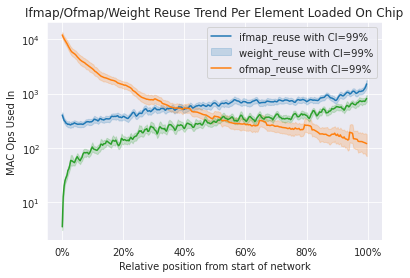

In [89]:

sns.lineplot(
    data=df, x="idxs", y="ifmap_reuse", ci=99
)
sns.lineplot(
    data=df, x="idxs", y="weight_reuse", ci=99
)
se_plt = sns.lineplot(
    data=df, x="idxs", y="ofmap_reuse", ci=99
)
se_plt.legend(['ifmap_reuse with CI=99%', 'weight_reuse with CI=99%', 'ofmap_reuse with CI=99%'])

se_plt.xaxis.set_major_formatter(PercentFormatter())
plt.xlabel('Relative position from start of network')
plt.yscale('log', base = 10)
plt.ylabel('MAC Ops Used In')
plt.title('Ifmap/Ofmap/Weight Reuse Trend Per Element Loaded On Chip')


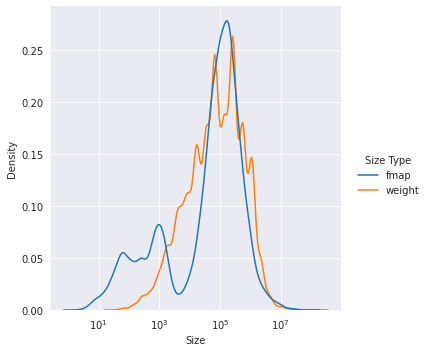

In [149]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties = layer_properties[layer_properties['type'] == 'conv']

new_records = []
for record in layer_properties[['original_ifmap_mem_size', 'original_ofmap_mem_size', 'original_weight_mem_size']].to_records():
    new_records.append((record[0], record[1], 'fmap', record[2]))
    # new_records.append((record[0], record[1], 'ofmap', record[3]))
    new_records.append((record[0], record[1], 'weight', record[4]))
df = pd.DataFrame.from_records(new_records, columns=['Model Name', 'Layer Name', 'Size Type', 'Size'])
plt = sns.displot(data = df, x = 'Size', hue='Size Type', log_scale=True, kind='kde')

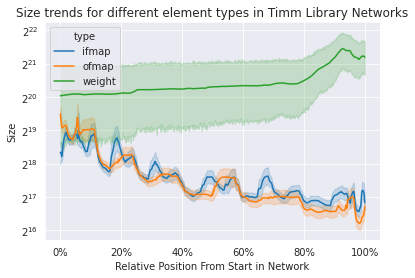

In [148]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties = layer_properties[layer_properties['type'] == 'conv']

def get_interp_size_per_model(
    layer_properties: pd.DataFrame, size_type: str, longest_network_length: int
):
    layer_prop_dict = layer_properties.to_dict(orient="index")
    mem_sizes = {}
    for (model_name, _), properties in layer_prop_dict.items():
        ifmap_mem_size = properties[size_type]
        try:
            mem_sizes[model_name].append(ifmap_mem_size)
        except KeyError as e:
            mem_sizes[model_name] = [ifmap_mem_size]
    interp_sizes = {}
    for model_name, values in mem_sizes.items():
        model_length = len(values)
        idx_list = np.linspace(0, longest_network_length, model_length)
        interp = np.interp(
            x = np.arange(longest_network_length), xp = idx_list, fp = values
        )
        interp_sizes[model_name] = interp
    return interp_sizes


longest_network_length = layer_properties.groupby(level=0).size().max()
interp_ifmap_sizes = get_interp_size_per_model(
    layer_properties, "original_ifmap_mem_size", longest_network_length
)
interp_ofmap_sizes = get_interp_size_per_model(
    layer_properties, "original_ofmap_mem_size", longest_network_length
)
interp_weight_sizes = get_interp_size_per_model(
    layer_properties, "original_weight_mem_size", longest_network_length
)
interp_ifmap_sizes

interp_sizes = {
    model_name: {
        "ifmap_mem": interp_ifmap_sizes[model_name],
        "ofmap_mem": interp_ofmap_sizes[model_name],
        "weight_mem": interp_weight_sizes[model_name],
    }
    for model_name in interp_ifmap_sizes.keys()
}
interp_sizes_as_records = []
for model_name, sizes in interp_sizes.items():
    for idx, (ifmap_size, ofmap_size, weight_mem) in enumerate(
        zip(sizes["ifmap_mem"], sizes["ofmap_mem"], sizes["weight_mem"])
    ):
        interp_sizes_as_records.append(
            {
                "model_name": model_name,
                "position": idx / longest_network_length * 100,
                "type": "ifmap",
                "size": ifmap_size,
            }
        )
        interp_sizes_as_records.append(
            {
                "model_name": model_name,
                "position": idx / longest_network_length * 100,
                "type": "ofmap",
                "size": ofmap_size,
            }
        )
        interp_sizes_as_records.append(
            {
                "model_name": model_name,
                "position": idx / longest_network_length * 100,
                "type": "weight",
                "size": weight_mem,
            }
        )
df = pd.DataFrame.from_records(interp_sizes_as_records).sort_values(['model_name', 'position'])
df.rename(columns={'position': "Relative Position From Start in Network", "size": "Size"}, inplace = True)
plt = sns.lineplot(
    data=df, x="Relative Position From Start in Network", y="Size", hue='type', ci=95
)
plt.set_yscale('log', base = 2)
plt.set_title('Size trends for different element types in Timm Library Networks')
plt.xaxis.set_major_formatter(mtick.PercentFormatter())


Text(0.5, 1.0, 'Frequency of kernel sizes in timm Library Layers')

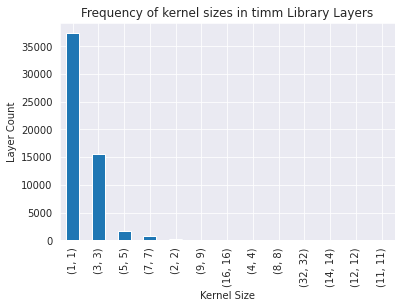

In [131]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties = layer_properties[layer_properties['type'] == 'conv']
freq = layer_properties['kernel_size'].value_counts()
plt = freq.plot(kind='bar')
plt.set_xlabel('Kernel Size')
plt.set_ylabel('Layer Count')
plt.set_title('Frequency of kernel sizes in timm Library Layers')

Text(0.5, 1.0, 'Boxplot of Kernel Size vs MACS for Timm Library Networks')

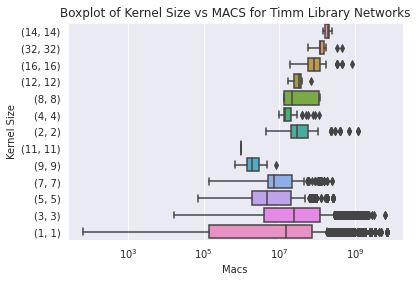

In [132]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties = layer_properties[layer_properties['type'] == 'conv']

macs_vs_ksize = layer_properties[["original_macs", "kernel_size"]].copy()
macs_vs_ksize.rename(columns={"kernel_size": "Kernel Size", "original_macs": "Macs"}, inplace=True)
plt = sns.boxplot(
    data=macs_vs_ksize,
    y="Kernel Size",
    x="Macs",
    order=macs_vs_ksize.groupby("Kernel Size").min().sort_values(by="Macs", ascending=False).index,
)
plt.set_xscale('log', base=10)
plt.set_title('Boxplot of Kernel Size vs MACS for Timm Library Networks')

Text(0.5, 1.0, "Boxplot of Kernel Size vs MACS for Timm Library Networks Weighted by a Kernel's frequency of occurence")

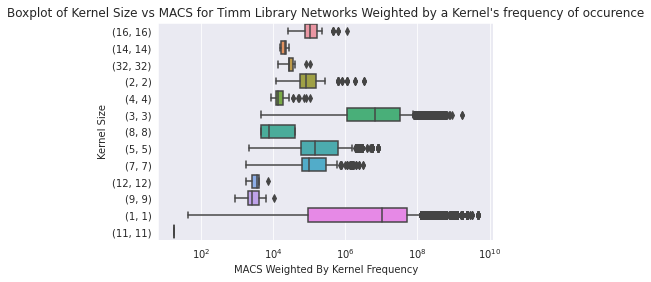

In [133]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties = layer_properties[layer_properties['type'] == 'conv']

macs_vs_ksize = layer_properties[["original_macs", "kernel_size"]]
freq = layer_properties["kernel_size"].value_counts()
macs_vs_ksize = macs_vs_ksize.assign(kernel_multipler=1)
for idx in freq.index:
    filtered_df = macs_vs_ksize[macs_vs_ksize["kernel_size"] == idx]
    macs_vs_ksize.loc[
        macs_vs_ksize.index.isin(filtered_df.index), "kernel_multipler"
    ] = freq[idx]
macs_vs_ksize["weighted_macs"] = (
    macs_vs_ksize["original_macs"] * macs_vs_ksize["kernel_multipler"] / np.sum(freq.values)
)
macs_vs_ksize.rename(columns={"kernel_size": "Kernel Size", "original_macs": "Macs", "weighted_macs": "MACS Weighted By Kernel Frequency"}, inplace=True)

plt = sns.boxplot(
    data=macs_vs_ksize,
    y="Kernel Size",
    x="MACS Weighted By Kernel Frequency",
    order=macs_vs_ksize.groupby("Kernel Size").min().sort_values(by="MACS Weighted By Kernel Frequency", ascending=False).index,
)
plt.set_xscale('log', base=10)
plt.set_title('Boxplot of Kernel Size vs MACS for Timm Library Networks Weighted by a Kernel\'s frequency of occurence')


In [139]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties = layer_properties[layer_properties['type'] == 'conv']
layer_properties


width  height  channels  in_channels  \
dla46x_c    base_layer.0             224     224         3          3.0   
            level0.0                 224     224        16         16.0   
            level1.0                 224     224        16         16.0   
            level2.project.0          56      56        32         32.0   
            level2.tree1.conv1       112     112        32         32.0   
...                                  ...     ...       ...          ...   
regnetx_064 s3.b10.conv2.conv         14      14       784        784.0   
            s4.b1.conv1.conv          14      14       784        784.0   
            s4.b1.conv2.conv          14      14      1624       1624.0   
            s4.b1.conv3.conv           7       7      1624       1624.0   
            s4.b1.downsample.conv     14      14       784        784.0   

                                   out_channels kernel_size  stride padding  \
dla46x_c    base_layer.0                   16.0      (7, 7)  (1, 1)  (3, 3)   
            level0.0                       16.0      (3, 3)  (1, 1)  (1, 1)   
            level1.0                       32.0      (3, 3)  (2, 2)  (1, 1)   
            level2.project.0               64.0      (1, 1)  (1, 1)  (0, 0)   
            level2.tree1.conv1             64.0      (1, 1)  (1, 1)  (0, 0)   
...                                         ...         ...     ...     ...   
regnetx_064 s3.b10.conv2.conv             784.0      (3, 3)  (1, 1)  (1, 1)   
            s4.b1.conv1.conv             1624.0      (1, 1)  (1, 1)  (0, 0)   
            s4.b1.conv2.conv             1624.0      (3, 3)  (2, 2)  (1, 1)   
            s4.b1.conv3.conv             1624.0      (1, 1)  (1, 1)  (0, 0)   
            s4.b1.downsample.conv        1624.0      (1, 1)  (2, 2)  (0, 0)   

                                  dilation  groups  ...         macs  \
dla46x_c    base_layer.0            (1, 1)     1.0  ...  118013952.0   
            level0.0                (1, 1)     1.0  ...  115605504.0   
            level1.0                (1, 1)     1.0  ...  231211008.0   
            level2.project.0        (1, 1)     1.0  ...    6422528.0   
            level2.tree1.conv1      (1, 1)     1.0  ...   25690112.0   
...                                    ...     ...  ...          ...   
regnetx_064 s3.b10.conv2.conv       (1, 1)    14.0  ...   77446656.0   
            s4.b1.conv1.conv        (1, 1)     1.0  ...  249550336.0   
            s4.b1.conv2.conv        (1, 1)    29.0  ...  160425216.0   
            s4.b1.conv3.conv        (1, 1)     1.0  ...  129231424.0   
            s4.b1.downsample.conv   (1, 1)     1.0  ...  249550336.0   

                                  ifmap_mem_size ofmap_mem_size  \
dla46x_c    base_layer.0               1053696.0     39342688.0   
            level0.0                    802816.0       802816.0   
            level1.0                   2408448.0     14451264.0   
            level2.project.0            100352.0       200704.0   
            level2.tree1.conv1          401408.0       802816.0   
...                                          ...            ...   
regnetx_064 s3.b10.conv2.conv           153664.0       153664.0   
            s4.b1.conv1.conv            153664.0       318304.0   
            s4.b1.conv2.conv            954912.0      2893968.0   
            s4.b1.conv3.conv             79576.0        79576.0   
            s4.b1.downsample.conv       153664.0       318304.0   

                                   weight_mem_size  original_macs  \
dla46x_c    base_layer.0                    2352.0    118013952.0   
            level0.0                        2304.0    115605504.0   
            level1.0                        4608.0     58320000.0   
            level2.project.0                2048.0      6422528.0   
            level2.tree1.conv1              2048.0     25690112.0   
...                                            ...            ...   
regnetx_064 s3.b10.conv2.conv   

/tmp/ipykernel_144530/569194365.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels(
/tmp/ipykernel_144530/569194365.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_y.set_yticklabels(


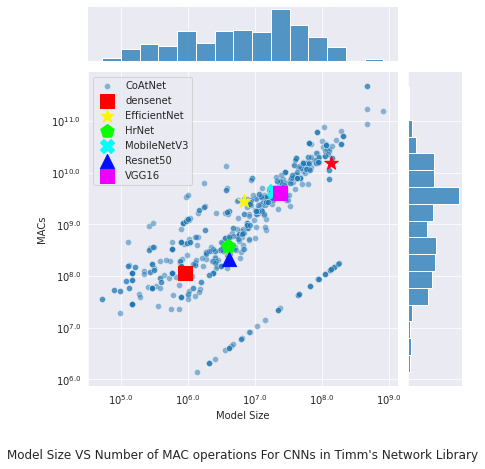

In [147]:
highlighted_models = {
    "vgg16": "VGG16",
    "resnet50": "Resnet50",
    "mobilenetv3_rw": "MobileNetV3",
    "efficientnet_b0": "EfficientNet",
    "coat_lite_small": "CoAtNet",
    "densenet121": "densenet",
    "hrnet_w18": "HrNet",
}

layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties = layer_properties[layer_properties['type'] == 'conv']

df = layer_properties[["original_macs", "weight_mem_size"]].groupby(level=0).sum()
df = np.log10(df)

df.rename(columns={"original_macs": "MACs", "weight_mem_size": "Model Size"}, inplace=True)
plt = sns.jointplot(data=df, y="MACs", x="Model Size", alpha=0.5)
plt.ax_marg_x.set_xticklabels(
    [r"$10^{" + str(i) + "}$" for i in plt.ax_marg_x.get_xticks()]
)
plt.ax_marg_y.set_yticklabels(
    [r"$10^{" + str(i) + "}$" for i in plt.ax_marg_y.get_yticks()]
)
plt.ax_joint.set_title(
    "Model Size VS Number of MAC operations For CNNs in Timm's Network Library", y=-0.25
)
color_iter = iter(cm.hsv(np.linspace(0, 1, len(highlighted_models))))
marker_iter = cycle(["o", "D", "s", "*", "p", "X", "^"])

legend = []
for model_name, macs, size in df.to_records():
    if model_name in highlighted_models.keys():
        legend.append(highlighted_models[model_name])
        plt.ax_joint.scatter(
            x=size, y=macs, marker=next(marker_iter), color=next(color_iter), s=200
        )
plt.ax_joint.legend(legend)


Text(0.5, 1.0, 'Networks With At Least One Layer with Kernel Size (k, k)')

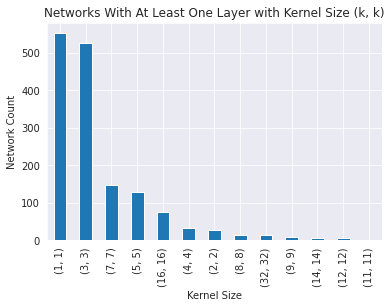

In [141]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties = layer_properties[layer_properties['type'] == 'conv']
kernel_sizes = layer_properties['kernel_size'].unique()

series = (layer_properties['kernel_size'].groupby(level=0).value_counts())
records = []

kernel_default_counter = Counter(kernel_sizes)
kernel_default_counter.subtract(kernel_default_counter)
kernel_default_counter = dict(kernel_default_counter)
model_counter = {}
for (model_name, kernel_size), freq in series.iteritems():
    try:
        model_counter[model_name][kernel_size] += 1
    except KeyError as e:
        model_counter[model_name] = kernel_default_counter.copy()
        model_counter[model_name][kernel_size] += 1
df = pd.DataFrame.from_dict(model_counter, orient='index')
plt = df.sum(axis=0).sort_values(ascending=False).plot(kind='bar')
plt.set_xlabel('Kernel Size')
plt.set_ylabel('Network Count')
plt.set_title('Networks With At Least One Layer with Kernel Size (k, k)')